### Setup

H5 files are a replacement of loom files.

<b>Where to get them?</b><br>
1. These are part of the DNA and protein pipeline output
       
2. The sample h5 used in this workflow can be found [here](https://github.com/MissionBio/mosaic-vignettes/tree/master/basics)


<i>Note: This is a h5 file trimmed specifically for this analysis</i>

In [3]:
import missionbio.mosaic.io as mio

h5path = './id451.dna_protein.analyzed.h5'
sample = mio.load(h5path, raw=False)

Loading, ../missionbio_analysis/id451.dna_protein.analyzed.h5
Loaded in 0.1s.


In [4]:
import plotly as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd

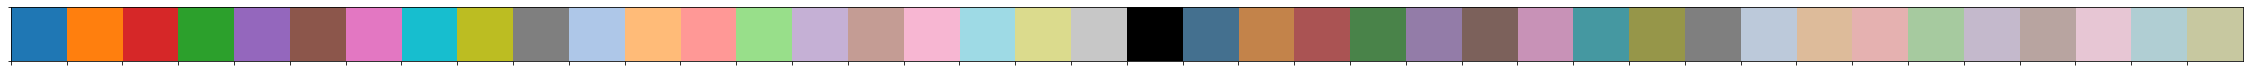

In [5]:

# Import the colors
from missionbio.mosaic.constants import COLORS

# additional color palettes: https://seaborn.pydata.org/tutorial/color_palettes.html

# Plot the first few colors
import seaborn as sns
sns.palplot(COLORS[:40])

In [6]:
from missionbio.h5.constants import AF, BARCODE, DNA_READ_COUNTS_ASSAY, PROTEIN_ASSAY, SAMPLE
print(AF)
print(PROTEIN_ASSAY)

AF
protein_read_counts


In [7]:
def clone_vs_analyte_custcol(samp, analyte='cnv', plot_width=0, plot_height=0, 
                             cols1=sns.cubehelix_palette(40, rot=(-0.2), light=0.2, dark=0.9).as_hex()):
        """
        Set of summary plots to give a run overview.

        The plots have three portions:
            1) The left-most is the VAF vs subclone/variant table.
            2) The middle is the cell population count/fraction.
            3) It depends on the input:
                - If the analyte is cnv, it shows the read count distribution plot.
                - If the analyte is protein, it shows the violin plot of proteins.

        Parameters
        ----------
        analyte : str
            cnv or protein - to be used in the third plot.
        plot_width : float
            The width of the plot in points.
        """

        scale = 1
        gap = .03
        titlefontsize = 14

        dna = samp.dna
        if analyte == 'protein':
            analyte = samp.protein
        else:
            analyte = samp.cnv

        if analyte is None:
            raise Exception("Analyte is None. Please choose another analyte.")

        if set(dna.barcodes()) != set(analyte.barcodes()):
            raise Exception('The DNA assay does not contain the same barcodes as the given assay.'
                            ' Please make sure that these two assays of the sample object contain the same cells')

        nv = dna.shape[1]
        clust, clustind = np.unique(dna.get_labels(), return_inverse=True)

        clust_names = np.array([clust[i] for i in range(len(clust))])

        nc = len(clust)

        vaf, vafstd, pval, _ = dna.feature_signature(layer=AF)
        vaf = vaf / 100

        vaf = vaf.T

        clust_keep = np.array([np.sum(clustind == i) for i in range(nc)])
        clust_keep = np.where(clust_keep >= 0)[0]

        nc = len(clust_keep)
        w = 20
        h =10

        if analyte is None:
            h = nc
        else:
            if analyte.name == PROTEIN_ASSAY:
                h = nc
            else:
                h = nc * 1.5

        if plot_width > 0:
            w = plot_width
        if plot_height > 0:
            h = plot_height

        fig = plt.figure(figsize=(w, h))

        # Flatten the sample name array down to strings
        samplename = dna.title

        cols = [dna.get_palette()[i] for i in clust_names]
        vals = np.arange(len(cols)) / (len(cols) - 1)
        colors = list(zip(vals, cols))
        custom_color_map = LinearSegmentedColormap.from_list(
            name='custom_navy',
            colors=colors,
        )

        # First column
        ax = fig.add_axes([.05, .1, .01, .75])
        ims = ax.imshow(np.arange(len(np.unique(dna.get_labels())))[:, None], aspect='auto', origin='high', cmap=custom_color_map)

        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks(np.arange(nc))
        ax.set_yticklabels(clust_names, fontsize=titlefontsize)
        ax.set_ylim([nc - 0.5, -0.5])
        ax.set_ylabel('Subclones', fontsize=titlefontsize)

        # Clonal Heatmap
        x0 = (0.015 * nv + 0.08) * scale
        ax = fig.add_axes([0.06, 0.1, x0 - 0.06, 0.75])

        cols1 = list(zip(np.linspace(1 / 3, 1, len(cols1)), cols1))
        cols = [(0, "#000000"), (0.33, "#000000")]
        cols.extend(cols1)
        custom_color_map = LinearSegmentedColormap.from_list(
            name='vaf_map',
            colors=cols,
        )

        ims = ax.imshow(vaf.iloc[clust_keep, :].astype(float), aspect='auto', origin='high', vmin=-0.5, vmax=1, cmap=custom_color_map)

        if nv < 40:
            for i in range(nc):
                for j in range(nv):
                    if vaf.iloc[clust_keep[i], j] < 0:
                        ax.text(j, i, 'MIS', va='center', ha='center', color=[1, 1, 1, 1], fontsize=titlefontsize * 0.7)
                    elif vaf.iloc[clust_keep[i], j] < .1:
                        ax.text(j, i, 'WT', va='center', ha='center', color=[1, 1, 1, 1], fontsize=titlefontsize * 0.7)
                    elif vaf.iloc[clust_keep[i], j] > 0.9:
                        ax.text(j, i, 'HOM', va='center', ha='center', fontsize=titlefontsize * 0.7)
                    else:
                        ax.text(j, i, 'HET', va='center', ha='center', fontsize=titlefontsize * 0.7)

        ax.hlines(np.arange(nc) - 0.5, ax.get_xlim()[0], ax.get_xlim()[1], color=[0, 0, 0, 1], linewidth=1)

        xticklab = [s.replace(' - ', '\n') for s in vaf.columns]

        plt.title('Genotype', fontsize=titlefontsize)
        ax.set_xticks(np.arange(nv))
        ax.set_xticklabels(xticklab, rotation=90, fontsize=titlefontsize * 0.7)
        ax.set_yticks([])
        ax.set_ylim([nc - 0.5, -0.5])
        ax.set_xlabel('Variants', fontsize=titlefontsize)
        ax.grid(False)

        ax.annotate('Sample: ' + samplename, xy=(0.01, 1), xycoords='figure fraction', fontsize=18, verticalalignment='top')

        cbaxes = fig.add_axes([.97, .6, .02, .3])
        cbar = plt.colorbar(ims, cax=cbaxes, ticks=[-0.5, 0, 0.5, 1])
        cbar.set_ticklabels(['missing', '0', '50', '100'])
        plt.title('VAF')

        # Clonal bar graph
        ax = fig.add_axes([x0 + gap, 0.1, 0.04 * scale, 0.75])
        y = [sum(clustind == clust_keep[nc - 1 - i]) / len(clustind) * 100 for i in range(nc)]
        ax.barh(np.arange(nc), y, color=[dna.get_palette()[i] for i in clust_names][::-1])
        mn = np.mean(ax.get_xlim())
        for i in range(nc):
            ax.text(y[i] + (-mn * 0.08 if y[i] > 3 / 2 * mn else 0), i, s='{:,}'.format(np.sum(clustind == clust_keep[nc - 1 - i])),
                    ha='left' if y[i] < 3 / 2 * mn else 'right', va='center', fontweight='bold', rotation=-90,
                    fontsize=titlefontsize * 0.8)

        ax.set_xlim(ax.get_xlim())

        ax.vlines(np.arange(0, ax.get_xlim()[1], 10), ax.get_ylim()[0], ax.get_ylim()[1], color=[0, 0, 0, .3], linewidth=1)
        ax.set_yticks([])
        plt.xticks(fontsize=titlefontsize)
        ax.set_ylim([-0.5, nc - 0.5])

        plt.title('Counts', fontsize=titlefontsize)
        ax.set_xlabel('(%)', fontsize=titlefontsize)

        x0 = x0 + 0.04 * scale + gap

        # Analyte map
        if analyte is None:
            return

        if analyte.name == PROTEIN_ASSAY:
            protein = analyte
            w = 0.92 - x0

            pn = protein.shape[1]

            for p in range(pn):
                dat = {'Cluster': clust_names[clustind], 'Counts': protein.layers['normalized_counts'][:, p]}
                df = pd.DataFrame(data=dat)

                ax = fig.add_axes([x0 + gap + w / pn * p, 0.1, w / pn - 0.002, 0.75])
                ax = sns.violinplot(data=df, x='Counts', y='Cluster', width=0.9, ax=ax, orient='h',
                                    palette=dna.get_palette(), order=clust_names[clust_keep], scale='width')

                plt.xticks(fontsize=titlefontsize * 0.6)
                ax.set_yticks([])
                ax.set_ylim(ax.get_ylim())
                ax.set(xlabel=None)

                plt.title(protein.col_attrs['id'][p], fontsize=titlefontsize, rotation=90, va='bottom')
                if p == int(pn / 2):
                    plt.xlabel('Normalized Protein Reads')

                plt.ylabel('')

        if analyte.name == DNA_READ_COUNTS_ASSAY:
            cnv = analyte
            ax = fig.add_axes([x0 + gap, 0.1, 0.92 - x0, 0.75])
            cnt = 0

            if PLOIDY not in cnv.layers:
                raise Exception("Ploidy has not yet been computed for this assay. Run sample.cnv.compute_ploidy")

            cnv_dat = cnv.layers[PLOIDY].copy()
            na = cnv_dat.shape[1]
            nh = 50
            Hs = np.zeros((0, na))

            ids, features = cnv._get_ids_from_features('genes')
            order = cnv.col_attrs[GENE_NAME].copy().argsort()

            for c in range(nc):

                in_clust = (c == clustind)
                cnv_clust = cnv_dat[in_clust, :][:, order]

                x = np.arange(na)
                y = np.median(cnv_clust, axis=0)
                ax.plot(x, y + (nc - cnt - 1) * 6 + 1, color=[0, 0, 0, 1], linewidth=0, marker='s', markersize=3)

                nb = np.sum(in_clust)

                xx = np.array([[i for i in range(na)] for j in range(nb)])
                xx = xx.reshape(na * nb, 1)[:, 0]

                yy = cnv_clust.reshape(na * nb, 1)[:, 0]
                ybins = np.linspace(-1, 5, nh + 1)
                ybins[-1] = 100

                H, xedges, yedges = np.histogram2d(xx, yy, bins=(np.linspace(0.5, na + 0.5, na + 1), ybins))
                H = np.minimum(H, np.quantile(H, .995))
                H = H / np.max(H)
                Hs = np.concatenate((H.T, Hs), axis=0)

                cnt = cnt + 1

            bone = cm.get_cmap('bone', nh * 2)
            cmap = col.ListedColormap(bone(np.linspace(0, 1, nh * 2))[2 * nh:nh:-1])
            ax.imshow(Hs, origin='low', extent=[xedges[0], xedges[-1], 0, 6 * nc], cmap=cmap, aspect='auto', interpolation='none')

            un, ind, cnts = np.unique(features, return_index=True, return_counts=True)
            ticks = (ind + cnts / 2).astype(int)
            ax.set_xticks(ticks)
            ax.set_xticklabels(features[ticks], rotation='vertical')
            ax.yaxis.tick_right()
            yt = np.arange(1, 6 * nc)
            yt2 = (yt - 1) % 6
            ax.set_yticks(yt)
            ax.set_yticklabels(yt2.astype(str))
            ax.set_xlim([-0.5, na - 0.5])
            ax.set_ylim([0, 6 * nc])
            plt.title('Amplicon Read Distribution vs Subclone', fontsize=14)

            for line in ind:
                ax.plot([line - 0.5, line - 0.5], ax.get_ylim(), color=[.5, .5, .5, 1], linewidth=.5)

            for lines in range(6 * nc):
                ax.plot(ax.get_xlim(), [lines, lines], color=[0, 0, 0, 1], linewidth=.5, linestyle='dotted')
                ax.plot(ax.get_xlim(), [lines + 0.1, lines + 0.1], color=[1, 1, 1, 1], linewidth=.5, linestyle='dotted')
            for lines in range(0, 6 * nc, 6):
                ax.plot(ax.get_xlim(), [lines, lines], color=[0, 0, 0, 1], linewidth=1)



### Data Structure

[Dna](https://missionbio.github.io/mosaic/pages/missionbio.mosaic.dna.Dna.html), [Cnv](https://missionbio.github.io/mosaic/pages/missionbio.mosaic.cnv.Cnv.html), and [Protein](https://missionbio.github.io/mosaic/pages/missionbio.mosaic.protein.Protein.html) are sub classes of the [_Assay](https://missionbio.github.io/mosaic/pages/missionbio.mosaic.assay._Assay.html) class<br>
The information is stored in four ways, and the user<bR>
can change each of those<br>

    1. metadata (add_metadata / del_metadata):
        dictionary containing metrics of the assay

    2. row_attrs (add_row_attr / del_row_attr):
        dictionary which contains 'barcode' as one of
        the keys. All the values must be of the same
        length i.e. match the number of barcodes
        This is the attribute where 'label', 'pca',
        and 'umap' values are added

    3. col_attrs (add_col_attr / del_col_attr):
        dictionary which contains 'ids' as one of
        the keys. All the values must be of the same
        length i.e. match the number ids
        'ids' contains variants for DNA assays
        and anitobides for Protein assays

    4. layers (add_layer / del_layer):
        dictionary containing 'read_counts' as one of 
        the metrics. All the values have the shape
        (num barcodes) x (num ids). This is the attribute
        where 'normalized_counts' will be added

[Sample](https://missionbio.github.io/mosaic/pages/missionbio.mosaic.sample.Sample.html) holds the [Dna](https://missionbio.github.io/mosaic/pages/missionbio.mosaic.dna.Dna.html) and [Protein](https://missionbio.github.io/mosaic/pages/missionbio.mosaic.protein.Protein.html) information
    



[Go to the top](#Data-Structure)

### DNA Analysis

<b>Topcis covered</b><br>
1. Whitelist of variants
2. Manually selecting variants

#### Basic filtering

    Many filtering options are available
    use the documentation shared earlier,
    or the help() function to get the same
    information here

In [8]:
# Filter variants
# This is the default insights filtering method

dna_vars = sample.dna.filter_variants(min_std=20)
dna_vars

array(['DNMT3A:p.P9= - chr2-25536827-G-A', 'SF3B1 - chr2-198267770-G-GAA',
       'BRAF - chr7-140449071-C-G', 'EZH2 - chr7-148506396-A-C',
       'RAD21 - chr8-117868854-T-C',
       'WT1:p.A387Vfs*4 - chr11-32417907-G-GCCGA',
       '(PATH) FLT3:p.D835Y - chr13-28592642-C-A',
       'NF1:p.L234= - chr17-29508775-G-A', 'NF1 - chr17-29559932-C-A',
       'NF1 - chr17-29563076-T-TG', 'NF1 - chr17-29563085-T-TG',
       '(MISS) RUNX1:p.H255R - chr21-36206748-T-C',
       'RUNX1 - chr21-36421036-T-C'], dtype='<U41')

In [9]:
dna_vars = sample.dna.filter_variants(min_dp=10, min_gq=30, min_vaf=20, min_prct_cells=50, min_mut_prct_cells=1, min_std=20)
dna_vars

array(['DNMT3A:p.P9= - chr2-25536827-G-A', 'SF3B1 - chr2-198267770-G-GAA',
       'BRAF - chr7-140449071-C-G', 'EZH2 - chr7-148506396-A-C',
       'RAD21 - chr8-117868854-T-C',
       'WT1:p.A387Vfs*4 - chr11-32417907-G-GCCGA',
       '(PATH) FLT3:p.D835Y - chr13-28592642-C-A',
       'NF1:p.L234= - chr17-29508775-G-A', 'NF1 - chr17-29559932-C-A',
       'NF1 - chr17-29563076-T-TG', 'NF1 - chr17-29563085-T-TG',
       '(MISS) RUNX1:p.H255R - chr21-36206748-T-C',
       'RUNX1 - chr21-36421036-T-C'], dtype='<U41')

#### Whitelist

    Simply appnding the whitelist to the list of filtered
    variants is sufficient to then select the variants
    using the slice notation
    
    i.e. sample.dna[{list of barcodes}, {list of ids}]

In [10]:
whitelist = []

In [11]:
final_vars = whitelist + list(dna_vars)

In [12]:
# Selecting all cells and final variants

sample.dna = sample.dna[sample.dna.barcodes(), final_vars]

In [13]:
#Add annotation to the SNV using varsome (adds gene name, AA changes to variants)
#import missionbio.mosaic.utils as mutils
ann_ids = sample.dna.get_annotations()  # Run this on a filtered DNA sample - too many variants are not handled correctly by the method
sample.dna.add_col_attr('id', ann_ids)

In [14]:
## First diagnostic plot to evaluate variant quality. attribute or colorby arguments may be changed
#adding go.Figure(fig) command so that the figure is saved when exporting the notebook to HTML
#adding write_image function saves the picture in high-res (commented out below)
fig = sample.dna.stripplot(attribute='AF', colorby='NGT')
go.Figure(fig)
#fig.write_image("stripplot_example.png") # change resolution or file type via help(fig.write_image)

#### Clustering

    DNA has a custom clustering method called `find_clones`
    
    It projects the data on a UMAP and then performs
    dbscan to identify unique clusters, which are then
    merged in case they were formed due to missing
    information

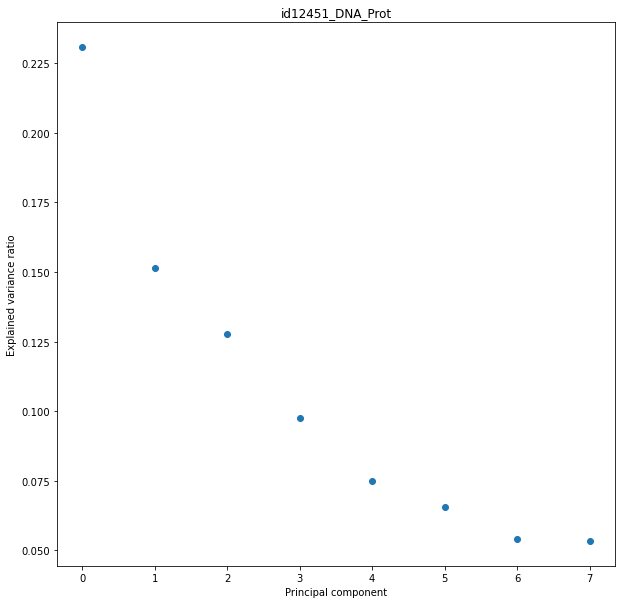

In [18]:
sample_clust2 = sample
#1 run PCA on data frame using AF_MISSING for instance
#(note, AF_MISSING includes -50 values for all 0 values for which the data was filtered and is missing)
sample_clust2.dna.run_pca(components=8, attribute='AF_MISSING',show_plot=True) # component # should equal # of PF variants
# Assess 'elbow' plot and determine number of PCs where the distribution starts to plateau. Note that PC1 = 0 in the plot

In [19]:
#rerun PCA w/ optimal PC number based on elbow plot analysis
sample_clust2.dna.run_pca(components=4, attribute='AF_MISSING')

In [21]:
#run UMAP on top of the newly created PC dataframe. 
#See https://jlmelville.github.io/uwot/abparams.html for appropriate spread/min_dist values
sample_clust2.dna.run_umap(attribute='pca', min_dist=0.2, spread=1.5, random_state=40)

In [22]:
#visualize data and cluster it using different methods
sample_clust2.dna.cluster(attribute='umap', method='dbscan')#, eps=0.8)

In [23]:
#replot UMAP projection w/ alternative clustering results
select_bars = sample_clust2.dna.barcodes(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15'])

sample_subset = sample_clust2[select_bars]
fig = sample_subset.dna.scatterplot(attribute='umap', colorby='label')
go.Figure(fig)

['#471365',
 '#482374',
 '#46327e',
 '#424086',
 '#3d4e8a',
 '#365c8d',
 '#31688e',
 '#2c738e',
 '#277f8e',
 '#238a8d',
 '#1f968b',
 '#1fa187',
 '#26ad81',
 '#35b779',
 '#4ac16d',
 '#65cb5e',
 '#81d34d',
 '#a0da39',
 '#c0df25',
 '#dfe318']

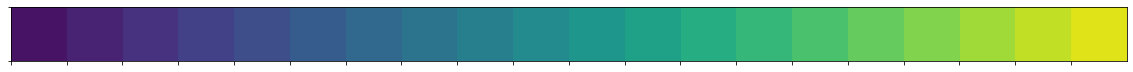

In [24]:
vir20 = sns.color_palette("viridis", n_colors=20).as_hex()
sns.palplot(vir20)
vir20

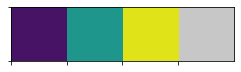

In [25]:
fig.layout.coloraxis.colorscale
# Assuming these are new desired colors
# NGT=0 (WT) - blue
# NGT=1 (HET) - orange
# NGT=2 (HOM) - red
# NGT=3 (missing) - black

# Additional information re: color palettes here: https://seaborn.pydata.org/tutorial/color_palettes.html

wt_col = vir20[0]
het_col = vir20[10]
hom_col = vir20[19]
miss_col = COLORS[19]

sns.palplot([wt_col, het_col, hom_col, miss_col])

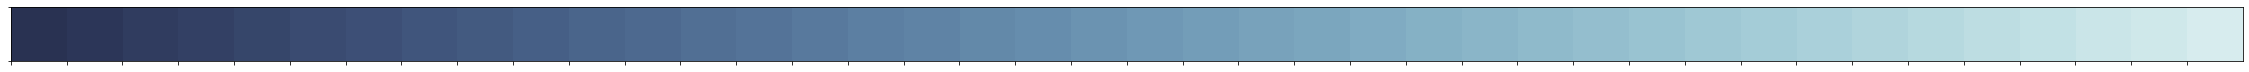

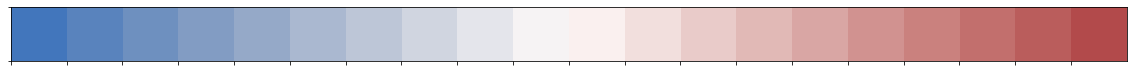

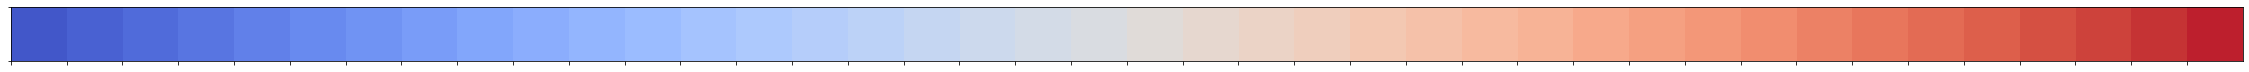

In [26]:
wt_col = vir20[0]
het_col = vir20[10]
hom_col = vir20[19]
miss_col = COLORS[19]

cub = sns.cubehelix_palette(40, rot=(-0.2), light=0.2, dark=0.9).as_hex()
sns.palplot(cub)
len(cub)

vlag = sns.color_palette("vlag", n_colors=20).as_hex()
sns.palplot(vlag)

warmcool = sns.color_palette("coolwarm", n_colors=40).as_hex()
sns.palplot(warmcool)

In [27]:
# Update the coloraxis to make a plot with the new colors

new_colors = [(0 / 4, wt_col), (1 / 4, wt_col),
              (1 / 4, het_col), (2 / 4, het_col),
              (2 / 4, hom_col), (3 / 4, hom_col),
              (3 / 4, miss_col), (4 / 4, miss_col)]

fig.layout.coloraxis.colorscale = new_colors
fig


FigureWidget({
    'data': [{'customdata': array([['label: 1<br>AACAACCTAATATAGCGT'],
                        …

### Protein Analysis

<b>Topics covered</b>
1. Basic workflow
2. Custom methods by adding layers

#### Basic workflow

In [28]:
sample_clust2.protein.normalize_reads('CLR') # three different methods avlb: CLR = center-log-transformed here

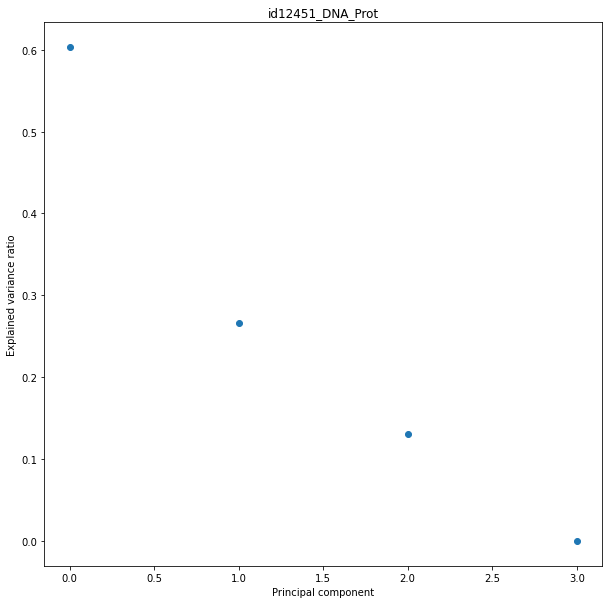

In [29]:
sample_clust2.protein.run_pca(attribute='normalized_counts', components=45,show_plot=True)

In [30]:
sample_clust2.protein.run_pca(attribute='normalized_counts', components=10)

In [31]:
sample_clust2.protein.run_umap(attribute='pca',spread=2,min_dist=0.4,random_state=42)

In [32]:
sample_clust2.protein.cluster(attribute='umap', method='graph-community',k=100) 

Creating the Shared Nearest Neighbors graph.
--------------------------------------------------
##################################################
Identifying clusters using Louvain community detection.

Number of clusters found: 12.
Modularity: 0.867


#### Custom methods by adding layers

In [33]:
# Custom normalization by changing the `normalized_counts` layer

import numpy as np

log_reads = np.log10(10 + sample_clust2.protein.layers['read_counts'])
norm = np.divide(log_reads, log_reads.mean(axis=1).reshape(-1, 1))

sample_clust2.protein.add_layer('normalized_counts', norm)

### Combined Visualizations

In [34]:
# Certain clones can also be dropped, but they must be dropped from all assays
# Hence the sample object is sliced in this case
# In this case it is better to store the new sample in a separate variable

# This returns the dna barcodes with the given labels
select_bars_clust2 = sample_clust2.dna.barcodes(['1','2', '3', '4', '5'])
sample_subset_clust2 = sample_clust2[select_bars_clust2]


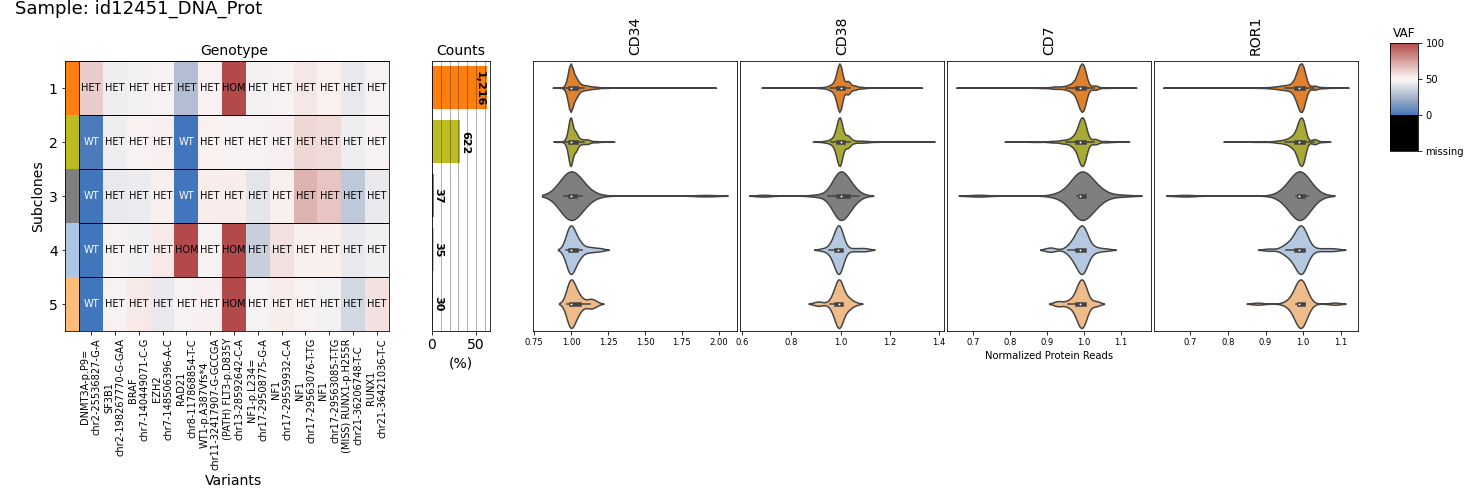

In [35]:
clone_vs_analyte_custcol(sample_subset_clust2, analyte='protein', plot_height=5, cols1=vlag)

#### Multi assay heatmap

[(0.0, '#4276bc'), (0.25, '#4276bc'), (0.25, '#f6f3f4'), (0.5, '#f6f3f4'), (0.5, '#b24a4b'), (0.75, '#b24a4b'), (0.75, '#7f7f7f'), (1.0, '#7f7f7f')]
[(0.0, '#471365'), (0.25, '#471365'), (0.25, '#1f968b'), (0.5, '#1f968b'), (0.5, '#dfe318'), (0.75, '#dfe318'), (0.75, '#c7c7c7'), (1.0, '#c7c7c7')]


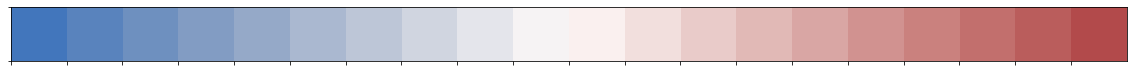

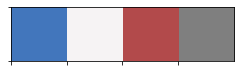

In [36]:
# Assuming these are new desired colors
# NGT=0 (WT) - blue
# NGT=1 (HET) - orange
# NGT=2 (HOM) - red
# NGT=3 (missing) - black
dark = sns.color_palette("dark", n_colors=10).as_hex()
tab10 = sns.color_palette("tab10", n_colors=10).as_hex()
vlag = sns.color_palette("vlag", n_colors=20).as_hex()
sns.palplot(vlag)
wt_col2 = vlag[0]
het_col2 = vlag[9]
hom_col2 = vlag[19]
miss_col2 = tab10[7]

sns.palplot([wt_col2, het_col2, hom_col2, miss_col2])
new_colors2 = [(0 / 4, wt_col2), (1 / 4, wt_col2),
              (1 / 4, het_col2), (2 / 4, het_col2),
              (2 / 4, hom_col2), (3 / 4, hom_col2),
              (3 / 4, miss_col2), (4 / 4, miss_col2)]

print(new_colors2)
print(new_colors)

In [37]:
fig = sample_subset_clust2.heatmap(clusterby='dna', sortby='dna', drop='cnv', flatten=False)
fig.layout.coloraxis.colorscale = new_colors2
print(fig.layout.coloraxis.colorscale)

go.Figure(fig)

((0.0, '#4276bc'), (0.25, '#4276bc'), (0.25, '#f6f3f4'), (0.5, '#f6f3f4'), (0.5, '#b24a4b'), (0.75, '#b24a4b'), (0.75, '#7f7f7f'), (1.0, '#7f7f7f'))


In [38]:
py.io.write_image(fig, 'Tapestri_451_Heatmap_12072022.pdf', format='pdf', scale=2, height=780, width=1080)

[Go to the top](#Combined-Visualizations)

### Saving

    The analysis can be saved to an h5 file.
    This final trimmed file will be much smaller than the original h5 file.
    It can be opened in Insights, or back again in Mosaic

In [ ]:
mio.save(sample, '../missionbio_analysis/id451.dna_protein.analyzed.h5')

    Data from h5 files can be efficiently manipulated,
    visualized, and inferred using Mosaic.